In [2]:
import os
import pydicom
import pandas as pd
import gzip
import shutil
import json
import csv
import numpy as np
import SimpleITK as sitk
from datetime import datetime
from rt_utils import RTStructBuilder
import platform
import dateutil
import argparse
import textwrap
import sys
import nibabel as nib
import matplotlib.pyplot as plt
import math
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import warnings
from rich.progress import track
warnings.filterwarnings("ignore")

from all_constants import *

gt_columns = ["Ground Truth Conversion Type",
              "Mean Sagittal Dice", "Mean Sagittal Dice Error",
              "Mean Coronal Dice", "Mean Coronal Error",
              "Mean Absolute Error Sagittal sTMTV",
              "Mean Absolute Error Sagittal sTMTV Error",
              "Mean Absolute Error Coronal sTMTV",
              "Mean Absolute Error Coronal sTMTV Error",
              "Mean Absolute Error Total sTMTV",
              "Mean Absolute Error Total sTMTV Error"]
def get_abs_errs(lst_of_two_entry_lists):
    """ 
    Given n entries each containing two lists, compute the absolute
    differences (errors) between the two list and provide all these
    in the same order
    """
    abs_errs = []
    for two_entry in lst_of_two_entry_lists:
        lsta = two_entry[0]
        lstb = two_entry[1]
        
        lstab_abs_errs = []
        for a,b in zip (lsta, lstb):
            abs_err = abs(a-b)
            lstab_abs_errs.append(abs_err)
        abs_errs.append(lstab_abs_errs)
    return abs_errs
        
def get_gt_result_dict(gt_convs, sag_dices, cor_dices, sag_abs_errs, cor_abs_errs, tot_abs_errs):
    """
    For each gt conversion method, provide the sag_dice_scores, 
    cor_dice_scores, sag_tmtvs, cor_tmtvs, tot_tmtvs in that order
    """
    gt_result_dict = {}
    conv_names = []
    sag_dice_lst, cor_dice_lst, sag_tmtv_lst, cor_tmtv_lst, tot_tmtv_lst = [],[],[],[],[]
    results_lsts = [sag_dice_lst, cor_dice_lst, sag_tmtv_lst,
                    cor_tmtv_lst, tot_tmtv_lst]
    data_lsts = [sag_dices, cor_dices, sag_abs_errs,
                 cor_abs_errs, tot_abs_errs]
    data_ixs = [SAG_DICE, COR_DICE, SAG_TMTV, COR_TMTV, TOT_TMTV]
    
    for gt_key in gt_keys:
        conv_name = gt_dict[gt_key]
        conv_names.append(conv_name)
        for results_lst, data_lst in zip(results_lsts, data_lsts):
            scores = []
            for ix, conv_type in enumerate(gt_convs):
                if (conv_type==conv_name):
                    scores.append(data_lst[ix])
            results_lst.append(scores)
    gt_result_dict[CONV_TYPE] = conv_names
    for data_ix, result_lst in zip(data_ixs, results_lsts):
        gt_result_dict[data_ix] = result_lst
    
    return gt_result_dict
           
def make_plots(data, names, input_dir, dice, cut): 
    """ 
    Make the appropriate boxplots
    """
    bp = plt.boxplot(data, showmeans=True)
    plt.xticks([1,2,3,4], names)
    cut_name = cut_dict[cut]
    if dice:
        title = f"{cut_name} Dice Scores"
        box_plot_y_axis = "Dice Score"
        fi_name = "Dice"
    else:
        title = f"{cut_name} sTMTV Absolute Errors"
        box_plot_y_axis = "sTMTV ($mm^2$)"
        fi_name = "TMTV"
    plt.title(title)
    plt.rcParams['figure.figsize']=(10,10)
    plt.xlabel(box_plot_x_axis)
    plt.ylabel(box_plot_y_axis)
    plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'],
               loc='upper center')
    plt.savefig(os.path.join(input_dir,
                             cut_name+"_"+fi_name+"_"+box_plot_fi_name),
                dpi=300)
    plt.clf()

def make_dice_boxplots(gt_data_dict, input_dir):
    """
    Provide the box plots for the four gt conversion methods
    """
    make_plots(gt_data_dict[SAG_DICE], gt_data_dict[CONV_TYPE],
               input_dir, dice=True, cut=0)
    make_plots(gt_data_dict[COR_DICE], gt_data_dict[CONV_TYPE],
               input_dir, dice=True, cut=1)
    
def make_tmtv_boxplot(gt_data_dict, input_dir):
    """
    Provide the box plots for the four gt conversion methods
    """
    make_plots(gt_data_dict[SAG_TMTV], gt_data_dict[CONV_TYPE],
               input_dir, dice=False, cut=0)
    make_plots(gt_data_dict[COR_TMTV], gt_data_dict[CONV_TYPE],
               input_dir, dice=False, cut=1)
    make_plots(gt_data_dict[TOT_TMTV], gt_data_dict[CONV_TYPE],
               input_dir, dice=False, cut=2)
    
def make_comparison_table(gt_data_dict, input_dir):
    """
    Compute all the mean average values and store them in .csv file
    """
    entries = []

    for ix in np.arange(len(gt_data_dict[CONV_TYPE])):
        entry = [gt_data_dict[CONV_TYPE][ix]]
        for data_type in [SAG_DICE, COR_DICE, SAG_TMTV, COR_TMTV, TOT_TMTV]:
            entry_elem = np.mean(gt_data_dict[data_type][ix])
            entry.append(entry_elem)
            entry_elem = np.std(gt_data_dict[data_type][ix])
            entry.append(entry_elem)
        entries.append(entry)
    df = pd.DataFrame(entries, columns = gt_columns)
    df.to_csv(os.path.join(input_dir, gt_mae_csv_fi), index=False)
    
def get_overall_results(input_dir):
     """ 
     Provide the box plots and table to
     illustrate the mean absolute errors
     """   
     result_fi_path = os.path.join(input_dir, combined_results_fi)
     results = pd.read_csv(result_fi_path)
     results = results[results["Case"].str.contains("PETCT") == False]  
     results.reset_index(drop=True, inplace = True)   
     gt_convs = results[gt_conv_csv_index]
     sag_dices, cor_dices =results[sag_dice_csv_index], results[cor_dice_csv_index]
     pred_sag_tmtvs, gt_sag_tmtvs = results[pred_sag_tmtv_csv_index], results[gt_sag_tmtv_csv_index]
     pred_cor_tmtvs, gt_cor_tmtvs = results[pred_cor_tmtv_csv_index], results[gt_cor_tmtv_csv_index]
     pred_tot_tmtvs, gt_tot_tmtvs = results[pred_tot_tmtv_csv_index], results[gt_tot_tmtv_csv_index]
     
     sag_abs_errs, cor_abs_errs, tot_abs_errs = get_abs_errs([ [pred_sag_tmtvs, gt_sag_tmtvs], [pred_cor_tmtvs, gt_cor_tmtvs], [pred_tot_tmtvs, gt_tot_tmtvs]])
     
     gt_result_dict = get_gt_result_dict(gt_convs, sag_dices, cor_dices, sag_abs_errs, cor_abs_errs, tot_abs_errs)    
     make_dice_boxplots(gt_result_dict, input_dir)
     make_tmtv_boxplot(gt_result_dict, input_dir)
     make_comparison_table(gt_result_dict, input_dir)

In [64]:
get_overall_results("/home/jhubadmin/qurit/dicom2nifti/gt_exp/results")

<Figure size 1000x1000 with 0 Axes>

In [16]:
convs_methods = df['GT Conversion Method']
cases = df["Case"]
sag_dice = df['Sagittal Dice Score']
cor_dice = df['Coronal Dice Score']
sag_tmtv = df['Predicted Sagittal TMTV']
cor_tmtv = df['Predicted Coronal TMTV']
tot_tmtv = df['Predicted Total TMTV']

In [17]:
ref_conv = "dcmrtstruct2nii"
ixs = []
sag_dices = []
cor_dices = []
sag_tmtvs = []
cor_tmtvs = []
tot_tmtvs = []
for ix, conv_method in enumerate(convs_methods):
    if (conv_method==ref_conv):
        sag_dices.append(sag_dice[ix])
        cor_dices.append(cor_dice[ix])
        sag_tmtvs.append(sag_tmtv[ix])
        cor_tmtvs.append(cor_tmtv[ix])
        tot_tmtvs.append(tot_tmtv[ix])

In [18]:
import numpy as np
print("sag_dice", np.std(sag_dices), np.mean(sag_dices))
print("cor_dice", np.std(cor_dices), np.mean(cor_dices))
print("sag_tmtv", np.std(sag_tmtvs), np.mean(sag_tmtvs))
print("cor_tmtv", np.std(cor_tmtvs), np.mean(cor_tmtvs))
print("tot_tmtv", np.std(tot_tmtvs), np.mean(tot_tmtvs))


sag_dice 0.3349112989474055 0.2311480170219119
cor_dice 0.3531539882226585 0.3016687609175437
sag_tmtv 215.1102699564592 152.91666666666666
cor_tmtv 196.4130407119863 120.63888888888889
tot_tmtv 6474.171803652563 4376.888888888889


In [3]:
import nibabel as nib
from rich.progress import track

results_dir = "/home/jhubadmin/qurit/dicom2nifti/gt_exp/results"
x_dir = "dcmrtstruct2nii"
y_dir = "lifex"
z_dir = "rt_utils"
u_dir = "slicer"
ai_dir = "ai_dir"
pred_dir = "predicted_data"
gt_suffix = "ground_truth.nii"

fi = open("/home/jhubadmin/qurit/dicom2nifti/gt_exp/results/dcmrtstruct2nii/ai_dir/cases.txt", "r")
_cases = fi.readlines()
cases = []
for _case in _cases:
    case = _case.replace("\n", "")
    cases.append(case)

def get_gt_file(gt_dir):
    for fi in os.listdir(gt_dir):
        if fi.endswith(gt_suffix):
            gt_fi = fi
    gt_img = nib.load(os.path.join(gt_dir, gt_fi))
    
    return gt_img

def compute_dice(img1, img2, eps=0):
    """
    Compute the dice score between two images where
    """
    img1_area = img1.sum()
    img2_area = img2.sum()
    intersection = np.logical_and(img1, img2).sum()
    dice = 2*intersection / (img1_area + img2_area+eps)
    return dice


def compute_dices(img1, img2):
    """
    Compute the two dice-scores of the two images

    cut_dict = {0:'Sagittal', 1: 'Coronal'}
    """
    scores = []
    for cut in cuts:
        img1_cut = img1.get_fdata()[cut, :, :]
        img2_cut = img2.get_fdata()[cut, :, :]
        cut_dice=compute_dice(img1_cut, img2_cut)
        scores.append(cut_dice)

    return scores

X="X"
Y="Y"
Z="Z"
U="U"

gt_conv_keys = [X, Y, Z, U]
gt_conv_dict = {
    X : "dcmrtstruct2nii",
    Y : "lifex",
    Z : "slicer",
    U : "rt_utils"
}

def get_gt_dir(gt_conv_key, case, series_method):
    match gt_conv_key:
        case "X":
            gt_conv_dir = x_dir
        case "Y" :
            gt_conv_dir = y_dir
        case "Z" :
            gt_conv_dir = z_dir
        case "U" :
            gt_conv_dir = u_dir
    gt_dir = os.path.join(results_dir, gt_conv_dir, ai_dir, pred_dir, case+"_"+series_method)
    return gt_dir

def gt_gt_img(gt_conv_key, case, series_method):
    gt_dir = get_gt_dir(gt_conv_key, case, series_method)
    gt_img = get_gt_file(gt_dir)
    return gt_img

series_methods = ["dcm2niix", "dicom2nifti", "lifex", "sitk", "sitk", "dcmstack"]

# all_lsts = {
#     "xy_sag" : [],
#     "xy_cor" : [],
#     "xz_sag" : [],
#     "xz_cor" : [],
#     "xu_sag" : [],
#     "xu_cor" : [],
#     "yz_sag" : [],
#     "yz_cor" : [],
#     "yu_sag" : [],
#     "yu_cor" : [],
#     "zu_sag" : [],
#     "zu_cor" : [],
# }
def get_combos(n):
    """
    Given a number, provide all combinations between indices less than
    said number
    """
    if (n==0) or (n==1):
        raise SystemError('n too low')
    combos = []
    for x in np.arange(n):
        for y in np.arange(x+1, n,1):
            combos.append([x,y])
    return combos


vals = np.zeros(2,4,4)
for case in track(cases):
    if not(case.startswith("PETCT")):
        for series_method in series_methods:
            gt_imgs = {}
            for gt_conv_key in gt_conv_keys:
                gt_imgs[gt_conv_key] = gt_gt_img(gt_conv_key, case, series_method)
            dice_combos = []
            # titles_combos = []
            for combo in get_combos(len(gt_conv_keys)):
                n,m = combo
                combo_sag, combo_cor = compute_dices(gt_imgs[gt_conv_keys[n]], gt_imgs[gt_conv_keys[m]])
                vals[0][n][m] += combo_sag
                vals[1][n][m] += combo_sag
                
data = vals/len(cases)

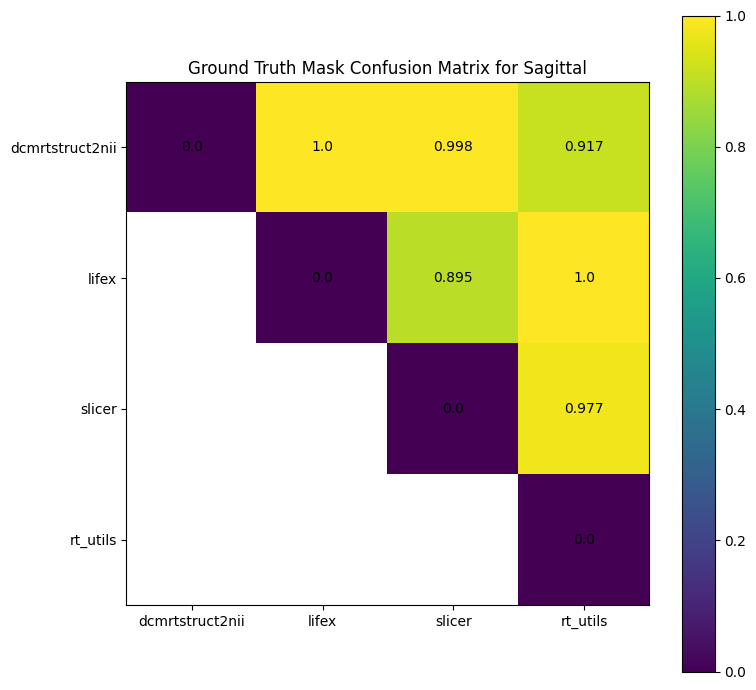

In [41]:
import numpy as np
import matplotlib.pyplot as plt
cut_dict = {
    0:'Sagittal',
    1: 'Coronal',
    2: 'Total'}
cut = 0

titles = ["dcmrtstruct2nii", "lifex", "slicer", "rt_utils"]
vals = np.array([
    [0, dice_combos[get_ix(cut, 0)], dice_combos[get_ix(cut, 1)], dice_combos[get_ix(cut, 2)]],
    [0, 0, dice_combos[get_ix(cut, 3)], dice_combos[get_ix(cut, 4)]],
    [0, 0, 0, dice_combos[get_ix(cut, 5)]],
    [0, 0, 0, 0],
])
vals = data[cut]
vals = np.around(vals, decimals=3)

plt.rcParams["figure.figsize"] = [8, 7]
plt.rcParams["figure.autolayout"] = True
mask = np.tri(vals.shape[0], k=-1)
data = np.ma.array(vals, mask=mask)
plt.imshow(data, interpolation="nearest", cmap='viridis', extent=[-1, 1, -1, 1])
plt.title(f"Ground Truth Mask Confusion Matrix for {cut_dict[cut]}")
plt.colorbar()
for (x,y),label in np.ndenumerate(vals):
    if x<=y:
        plt.text((-3+2*y)/4, (3-2*x)/4,label,ha='center',va='center')
plt.xticks(ticks = [-3/4, -1/4, 1/4, 3/4],
            labels = [titles[0], titles[1], titles[2], titles[3]])
plt.yticks(ticks = [-3/4, -1/4, 1/4, 3/4],
            labels = [titles[3], titles[2], titles[1], titles[0]])
# plt.savefig(os.path.join(case_dir, 'mask_vals.png'))
# plt.clf()
plt.show()

In [34]:
import numpy as np

np.around(vals, decimals=8)

array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [4]:
import numpy as np
def get_combos(n):
    """
    Given a number, provide all combinations between indices less than
    said number
    """
    if (n==0) or (n==1):
        raise SystemError('n too low')
    combos = []
    for x in np.arange(n):
        for y in np.arange(x+1, n,1):
            combos.append([x,y])
    return combos

get_combos(4)

[[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

In [18]:
import nibabel as nib
from rich.progress import track
import pandas as pd

results_dir = "/home/jhubadmin/qurit/dicom2nifti/gt_exp/results"
x_dir = "dcmrtstruct2nii"
y_dir = "lifex"
z_dir = "rt_utils"
u_dir = "slicer"
ai_dir = "ai_dir"
pred_dir = "predicted_data"
gt_suffix = "ground_truth.nii"

fi = open("/home/jhubadmin/qurit/dicom2nifti/gt_exp/results/dcmrtstruct2nii/ai_dir/cases.txt", "r")
_cases = fi.readlines()
cases = []
for _case in _cases:
    case = _case.replace("\n", "")
    cases.append(case)

def get_gt_file(gt_dir):
    for fi in os.listdir(gt_dir):
        if fi.endswith(gt_suffix):
            gt_fi = fi
    gt_img = nib.load(os.path.join(gt_dir, gt_fi))
    
    return gt_img

results = pd.read_csv("/home/jhubadmin/qurit/dicom2nifti/gt_exp/results/combined_results.csv")
results = results[results["Case"].str.contains("PETCT") == False]  
results.reset_index(drop=True, inplace = True)  

def compute_dice(img1, img2, eps=0):
    """
    Compute the dice score between two images where
    """
    img1_area = img1.sum()
    img2_area = img2.sum()
    intersection = np.logical_and(img1, img2).sum()
    dice = 2*intersection / (img1_area + img2_area+eps)
    return dice


def compute_dices(img1, img2):
    """
    Compute the two dice-scores of the two images

    cut_dict = {0:'Sagittal', 1: 'Coronal'}
    """
    scores = []
    for cut in cuts:
        img1_cut = img1.get_fdata()[cut, :, :]
        img2_cut = img2.get_fdata()[cut, :, :]
        cut_dice=compute_dice(img1_cut, img2_cut)
        scores.append(cut_dice)

    return scores

X="X"
Y="Y"
Z="Z"
U="U"

gt_conv_keys = [X, Y, Z, U]
gt_conv_dict = {
    X : "dcmrtstruct2nii",
    Y : "lifex",
    Z : "slicer",
    U : "rt_utils"
}

def get_gt_dir(gt_conv_key, case, series_method):
    match gt_conv_key:
        case "X":
            gt_conv_dir = x_dir
        case "Y" :
            gt_conv_dir = y_dir
        case "Z" :
            gt_conv_dir = z_dir
        case "U" :
            gt_conv_dir = u_dir
    gt_dir = os.path.join(results_dir, gt_conv_dir, ai_dir, pred_dir, case+"_"+series_method)
    return gt_dir

def gt_gt_img(gt_conv_key, case, series_method):
    gt_dir = get_gt_dir(gt_conv_key, case, series_method)
    gt_img = get_gt_file(gt_dir)
    return gt_img

series_methods = ["dcm2niix", "dicom2nifti", "lifex", "sitk", "sitk", "dcmstack"]

def get_combos(n):
    """
    Given a number, provide all combinations between indices less than
    said number
    """
    if (n==0) or (n==1):
        raise SystemError('n too low')
    combos = []
    for x in np.arange(n):
        for y in np.arange(x+1, n,1):
            combos.append([x,y])
    return combos
gt_convs = results[gt_conv_csv_index]
gt_cases = results["Case"]
gt_sag_tmtvs = results[gt_sag_tmtv_csv_index]
gt_cor_tmtvs = results[gt_cor_tmtv_csv_index]
gt_tot_tmtvs = results[gt_tot_tmtv_csv_index]

def get_gt_tmtv_data(gt_conv_key, case, series_method):
    for ix, gt_case in enumerate(gt_cases):
        if (gt_case == case):
            if (gt_convs[ix] == gt_conv_dict[gt_conv_key]):
                result= [gt_sag_tmtvs[ix], gt_cor_tmtvs[ix], gt_tot_tmtvs[ix]]
    return result

vals = np.zeros((3,4,4))
for case in cases:
    if not(case.startswith("PETCT")):
        for series_method in series_methods:
            gt_tmtv_data = {}
            for gt_conv_key in gt_conv_keys:
                gt_tmtv_data[gt_conv_key] = get_gt_tmtv_data(gt_conv_key, case, series_method)
            combo_tmtv_data = []
            
            for combo in get_combos(len(gt_conv_keys)):
                n,m = combo
                data_a = gt_tmtv_data[gt_conv_keys[n]]
                data_b = gt_tmtv_data[gt_conv_keys[m]]
                for i in np.arange(len(data_a)):
                    abs_err =abs(data_a[i] - data_b[i])
                    vals[i][n][m] += abs_err
                    
data = vals/len(cases)

In [63]:
vals

array([[[     0.,   2988.,   1464.,   3066.],
        [     0.,      0.,   1560.,   3174.],
        [     0.,      0.,      0.,   1650.],
        [     0.,      0.,      0.,      0.]],

       [[     0.,   2988.,   1464.,   3066.],
        [     0.,      0.,   1560.,   3174.],
        [     0.,      0.,      0.,   1650.],
        [     0.,      0.,      0.,      0.]],

       [[     0.,  92448.,  43680.,  95616.],
        [     0.,      0.,  58368., 110304.],
        [     0.,      0.,      0.,  54816.],
        [     0.,      0.,      0.,      0.]]])

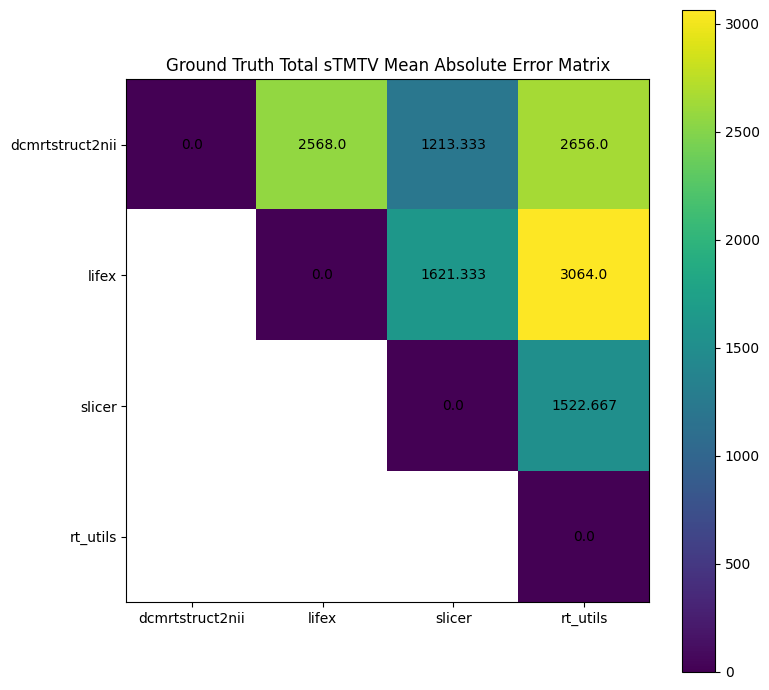

In [21]:
import numpy as np
import matplotlib.pyplot as plt
cut_dict = {
    0:'Sagittal',
    1: 'Coronal',
    2: 'Total'}
cut = 2
def get_ix(cut, ix):
    if cut==0:
        iy = 2*ix
    else:
        iy = 2*ix+1
    return ix

titles = ["dcmrtstruct2nii", "lifex", "slicer", "rt_utils"]
vals = data[cut]
vals = np.around(vals, decimals=3)

plt.rcParams["figure.figsize"] = [8, 7]
plt.rcParams["figure.autolayout"] = True
mask = np.tri(vals.shape[0], k=-1)
vals = np.ma.array(vals, mask=mask)
plt.imshow(vals, interpolation="nearest", cmap='viridis', extent=[-1, 1, -1, 1])
plt.title(f"Ground Truth {cut_dict[cut]} sTMTV Mean Absolute Error Matrix")
plt.colorbar()
for (x,y),label in np.ndenumerate(vals):
    if x<=y:
        plt.text((-3+2*y)/4, (3-2*x)/4,label,ha='center',va='center')
plt.xticks(ticks = [-3/4, -1/4, 1/4, 3/4],
            labels = [titles[0], titles[1], titles[2], titles[3]])
plt.yticks(ticks = [-3/4, -1/4, 1/4, 3/4],
            labels = [titles[3], titles[2], titles[1], titles[0]])
plt.savefig(os.path.join("/home/jhubadmin/qurit/dicom2nifti/gt_exp/high_res_data", f'{cut_dict[cut]}_confusion_matrix.png'),
            dpi=400)
# plt.clf()
#plt.show()